In [101]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, pdb, glob, time, fnmatch, datetime
from astropy.table import Table, vstack, hstack, Column, unique, join

def stop(): pdb.set_trace()

cat=Table.read('CatVisClass_AmberW_20220729.fits')

cat = cat[np.where((cat['maxcsig'] >= 8) & (cat['candfilt'] > 0))]
print(cat['objid','ra','dec', 'galb', 'maxcsig', 'zphot', 'zphoterr','visclass1'])


  objid          ra               dec        ...  zphoterr  visclass1
--------- ---------------- ----------------- ... ---------- ---------
 96790139 4.05959244523772 0.414876956198093 ... 0.00580527         2
 96790731 3.69769239053231   0.4909238138444 ...   0.014018         1
 96788687 3.72946894186312 0.252314959318044 ...   0.014018         1
125594234  3.6037687345893  6.66656128169744 ...   0.011961         3
140421937 2.30757381499709  9.68286839499233 ...  0.0139723         1
132247889 1.86010784383005  7.17715621317679 ...   0.014018         1
120826855 2.83295370296247  5.00666674001164 ...   0.014018         1
120819993 5.56679893073593  5.11024775212664 ...   0.014018         1
130832887 5.22096950367435  7.70827326137752 ...   0.014018         1
140345487 6.80293242158499  9.66101224378644 ...   0.014018         1
      ...              ...               ... ...        ...       ...
 97436840 116.306965682991 0.913175545836531 ...   0.014018         1
116668433 110.037264

In [103]:
cat_con = cat[np.where((cat['visclass1'] > 1) & (cat['visclass1'] < 5))]
cat_gal = cat[np.where(cat['visclass1'] == 1)]

perc_contamination = len(cat_con) / len(cat)
print(perc_contamination)


0.5802943058221369


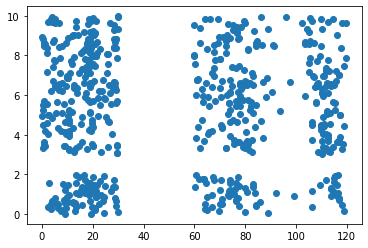

In [104]:
plt.scatter(cat_gal['ra'], cat_gal['dec'])


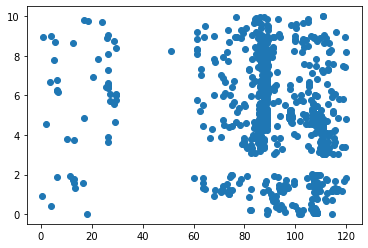

In [105]:
plt.scatter(cat_con['ra'], cat_con['dec'])


In [106]:
print(min(cat['galb']))
print(max(cat['galb']))

-62.7105
19.4226


In [107]:
# bin data from 0 to 65

bins = []
for i in range(0, 65, 5):
    cat_bin = cat[np.where((abs(cat['galb']) >= i) & (abs(cat['galb']) < i + 5))]
    perc = [len(cat_bin[np.where(cat_bin['visclass1'] == x)]) / len(cat_bin) if len(cat_bin) else 0 for x in range(1, 6)]
    bins.append(perc)
    
print(bins)

[[0.05847953216374269, 0.5087719298245614, 0.04678362573099415, 0.38011695906432746, 0.005847953216374269], [0.1452513966480447, 0.7737430167597765, 0.0782122905027933, 0.0, 0.002793296089385475], [0.2033898305084746, 0.692090395480226, 0.096045197740113, 0.005649717514124294, 0.002824858757062147], [0.6071428571428571, 0.29464285714285715, 0.09821428571428571, 0.0, 0.0], [0.618421052631579, 0.14473684210526316, 0.23684210526315788, 0.0, 0.0], [0.6071428571428571, 0.08928571428571429, 0.26785714285714285, 0.0, 0.03571428571428571], [0.6521739130434783, 0.17391304347826086, 0.15217391304347827, 0.0, 0.021739130434782608], [0.5, 0.0, 0.5, 0.0, 0.0], [0, 0, 0, 0, 0], [1.0, 0.0, 0.0, 0.0, 0.0], [0.7482014388489209, 0.04316546762589928, 0.16546762589928057, 0.0, 0.04316546762589928], [0.8589743589743589, 0.01282051282051282, 0.07051282051282051, 0.0, 0.057692307692307696], [0.7613636363636364, 0.06818181818181818, 0.03409090909090909, 0.0, 0.13636363636363635]]


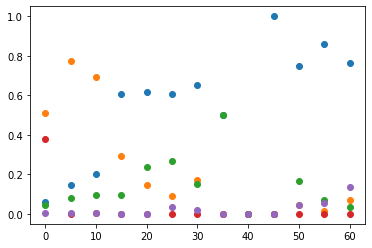

In [108]:
bins_gal = [i[0] for i in bins]
bins_star = [i[1] for i in bins]
bins_junk = [i[2] for i in bins]
bins_mw = [i[3] for i in bins]
bins_pog = [i[4] for i in bins]
label_x = [i for i in range(0, 65, 5)]

plt.scatter(label_x, bins_gal)
plt.scatter(label_x, bins_star)
plt.scatter(label_x, bins_junk)
plt.scatter(label_x, bins_mw)
plt.scatter(label_x, bins_pog)

In [ ]:
# plots
# binned fraction of different visclasses per galb
# ex: fraction of star detections per all detections per galb interval
# scatter/bar graph showing percentage of different detections per galb interval
# visualization of a patch of the sky; different symbols/colors for stars or galaxies
# histogram of maxcsig
# get labeled cutouts of the most extreme objects(top 10% maxcsig) into a collage
# identify how many detections are new (astroquery, cross-match against NED's known redshifts)
# two results: methodology and science; methodology = classification statistics; science = interesting, real galaxies (extreme objects)
# methodology: table of total number of candidates and how those break down into various statistics for each object class
# understand how that is distributed across the sky
# dec vs ra colorcoded classifications
# histogram/scatter of contaminations vs galb
# first motivation slide: show localizations of ligo wave events; we need to find galaxies to increase the efficiency of searches for them
# how do we find new galaxies? -> CLU survey
# we need human visual classification to sort out the stars and junk
# how i did classifications(examples, screenshots)
# statistics and plots
# science results: number of new objects and number of new extreme objects